This notebook is the cleaned up version of applying Lec 13 and 14 (along with prior notebook code) to the nba dataset. The goal is to build and fit 3 classification models (Logistic Regression, Decision Tree, and Random Forest) that will predict `won_game`. 

# 1. Imports, Setup, and Preprocessing

First import the libraries required for this notebook.

In [63]:
import numpy as np
import pandas as pd

# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

%matplotlib inline
import matplotlib.pylab as plt


from sklearn.feature_selection import VarianceThreshold
from dython.nominal import associations

#from feature_engine.encoding import MeanEncoder # will not be using MeanEncoder this time around
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Load in the dataset into `df` and prep it

In [2]:
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')
df = df[df['season'].str[:4].astype(int) > 2012] # Remove old seasons (only keeping seasons 2013-14 onward)
#df = df.loc[(df['distance'] != 0 ) & (df['touches'] != 0)] # exclude rows where 0 in certain columns doesnt make sense
df = df.dropna() # drop rows with missing values 
df = df.reset_index(drop=True) # reset index
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,41300405,2013-14,1610612759,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,12.0,26.0,0.462,18.0,23.0,0.783,6.0,34.0,40.0,5.0,4.0,8.0,21.0,104.0,17.0,115.4,116.9,92.7,97.8,22.7,19.1,0.676,3.13,20.6,0.178,0.750,0.473,8.877,9.0,0.551,0.590,1.0,0.200,92.00,89.0,74.17,89.0,0.622,17.60,32.0,61.0,90.0,467.0,4.0,1.0,357.0,25.0,18.0,38.0,0.474,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1,1,0
1,41300404,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,71.0,0.451,9.0,22.0,0.409,13.0,20.0,0.650,6.0,21.0,27.0,7.0,1.0,13.0,25.0,86.0,-21.0,99.1,101.2,128.9,127.4,-29.8,-26.2,0.406,1.00,12.3,0.000,0.000,0.000,14.977,15.3,0.514,0.539,1.0,0.203,84.90,84.5,70.42,85.0,0.297,16.83,21.0,38.0,57.0,377.0,0.0,1.0,274.0,13.0,14.0,30.0,0.467,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0,1,0
2,41300403,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,62.0,0.516,10.0,21.0,0.476,18.0,24.0,0.750,5.0,21.0,26.0,8.0,1.0,20.0,26.0,92.0,-19.0,105.1,108.2,128.9,129.1,-23.9,-20.8,0.531,0.85,15.5,0.229,0.733,0.462,22.841,23.5,0.597,0.634,1.0,0.199,86.82,85.5,71.25,85.0,0.365,16.36,21.0,40.0,57.0,361.0,2.0,0.0,256.0,17.0,16.0,31.0,0.516,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0,1,0
3,41300402,2013-14,1610612759,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,12.0,26.0,0.462,12.0,20.0,0.600,11.0,26.0,37.0,7.0,1.0,11.0,20.0,96.0,-2.0,105.7,109.1,108.6,110.1,-2.9,-1.0,0.722,2.36,20.3,0.260,0.000,0.000,12.115,12.5,0.512,0.529,1.0,0.196,90.52,88.5,73.75,88.0,0.478,16.80,25.0,37.0,60.0,436.0,6.0,1.0,325.0,26.0,17.0,40.0,0.425,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0,1,0
4,41300401,2013-14,1610612759,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,13.0,25.0,0.520,17.0,22.0,0.773,5.0,34.0,39.0,8.0,4.0,22.0,14.0,110.0,15.0,115.0,115.8,101.2,100.0,13.7,15.8,0.750,1.30,23.0,0.258,0.814,0.581,24.038,24.2,0.684,0.708,1.0,0.199,94.76,95.0,79.17,95.0,0.626,17.48,17.0,57.0,72.0,441.0,2.0,3.0,333.0,30.0,23.0,32.0,0.719,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1,1,0


Now to drop columns:
- dropping `game_id`, `team_id`, `team_name`, `tri_code`, `team_slug`, and `minutes`as they don't belong in the dataset for this pipeline
- because the dependent var is `won_game` we wil also drop columns that directly/indirectly indicate the final score  

In [3]:
try:
    drop_vars = [
        'game_id', 
        'team_id', 
        'team_name', 
        'tri_code', 
        'team_slug', 
        'season', # dropping for now but could technically be a cat dep var
        'minutes'] + ['points', 'opponent_points', 'plus_minus_points','field_goals_made',
'three_pointers_made',
'free_throws_made',
'contested_field_goals_made',
'uncontested_field_goals_made',
'defended_at_rim_field_goals_made']
    df = df.drop(drop_vars, axis=1)
    df.head()
except Exception as e:
    print('drop_vars already dropped')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   field_goals_attempted                  30060 non-null  float64
 1   field_goals_percentage                 30060 non-null  float64
 2   three_pointers_attempted               30060 non-null  float64
 3   three_pointers_percentage              30060 non-null  float64
 4   free_throws_attempted                  30060 non-null  float64
 5   free_throws_percentage                 30060 non-null  float64
 6   rebounds_offensive                     30060 non-null  float64
 7   rebounds_defensive                     30060 non-null  float64
 8   rebounds_total                         30060 non-null  float64
 9   steals                                 30060 non-null  float64
 10  blocks                                 30060 non-null  float64
 11  tu

We're also going to drop `is_playoff_game` on the basis that the games in the dataset have already been filtered to where they are either a regular or playoff game. A 0 for `is_regular_game` will implicitly indicate that the game is a playoff game

In [ ]:
df = df.drop(['is_playoff_game'], axis=1)

From the `df.info()`, all the numeric variables are float64 which is good. Our threee categorical variables (`is_home_team`, `won_game`, and `is_regular_game`) have already been converted into binary dummy variables, so we can skip changing the dtype recoding with `.cat.rename_categories()`. We will need to split up the numeric and categorical features into `df_num` and `df_cat` before moving on to multicolinearity/near zero variance steps.

In [7]:
cat_vars = ['is_home_team', 'won_game', 'is_regular_game']
df_cat = df[cat_vars]
df_num = df.drop(cat_vars, axis=1)

# assertion to ensure that split happened properly
assert df_cat.shape[1] + df_num.shape[1] == df.shape[1]

## Removing High Correlation
Now we need to remove the independent variables that are highly correlated with each other. To do this, we have a function we can define. (Since the dependent variable is categorical is will not exist in the df_num passed into the function.) 

In [8]:
# From John's notebook
def removeHighCorr (data,thresh):
  corr_matrix=associations(dataset=data, compute_only=True)['corr'].abs()
  upper_tri=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
  to_drop=[column for column in upper_tri.columns if any(upper_tri[column]>thresh)]
  new_data=data.drop(to_drop,axis=1)
  return new_data

In [ ]:
pre = df_num.shape[1]
df_num_nhc = removeHighCorr(df_num, 0.7) # _nhc --> no high corr
post = len(df_num_nhc.columns.tolist())

print(f'pre: {pre} \n post: {post}')

pre: 52 
 post: 25


Looks like 27 columns were eliminated

## Removing Near Zero Variance
Now we also need to remove variables with near-zero variance. Using sklearn's VarianceThreshold  to remove variables that may appear in the model but are not truly explanatory

In [10]:
pre = post

vt = VarianceThreshold(threshold=0.1)
vt.fit_transform(df_num_nhc)

cols = df_num_nhc.columns[vt.get_support()]
post = len(cols)

df_num_nhc_nnzv = df_num_nhc[cols] # _nnzv --> no near zero variance

print(f'pre: {pre} \n post: {post}')

pre: 25 
 post: 17


Looks like 8 columns were eliminated. Lets take a look at whats remaining after the feature elimination

In [11]:
df_num_nhc_nnzv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   field_goals_attempted       30060 non-null  float64
 1   three_pointers_attempted    30060 non-null  float64
 2   free_throws_attempted       30060 non-null  float64
 3   rebounds_offensive          30060 non-null  float64
 4   rebounds_defensive          30060 non-null  float64
 5   steals                      30060 non-null  float64
 6   blocks                      30060 non-null  float64
 7   turnovers                   30060 non-null  float64
 8   fouls_personal              30060 non-null  float64
 9   estimated_defensive_rating  30060 non-null  float64
 10  estimated_net_rating        30060 non-null  float64
 11  estimated_pace              30060 non-null  float64
 12  pace                        30060 non-null  float64
 13  distance                    300

Overall we went from 52 -> 17 features. The columns remaining intuitively make sense to include and cover a good range of nba game stats

*skipping scaling values as its not necessarily required for log reg*

## Final prep and Data Paritioning 

First we gotta merge the numeric and categorical variables back into `df_full`.

In [18]:
df_full = pd.concat([df_num_nhc_nnzv.reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

# checks to make sure merge happened properly since past experience as shown that incorrect merge will mess up the fitting

# assertion for row size (since feature elimination did not touch rows and only bad merge would mess it up)
assert df_full.shape[0] == df.shape[0] # df is right before split into _cat/_num 

# assertion for nulls (since nulls were cleaned out before feature elimination) 
assert df_full.isna().sum().sum() == 0

Looking for any significant class imbalance. By the nature of this dataset, we are expecting to see a close/exact 50-50 split

In [ ]:
ct = pd.crosstab(index=df_full['won_game'], columns='count')
ct_norm = ct / ct.sum() # to show percentages
ct_norm

col_0,count
won_game,
0,0.5
1,0.5


Now onto data partitioning. 80% for training and 20% for testing

In [19]:
dep_var_name = 'won_game'

dep_var = df_full[dep_var_name]
ind_var = df_full.drop([dep_var_name], axis=1)

# data partitioning
train_X, test_X, train_y, test_y = train_test_split(ind_var, dep_var, test_size=0.2, random_state=42)

Following are assertions that should hold. Included since I end up running them anyway as part of troubleshooting when something goes wrong. 


If any of these proc an error, it means something went wrong earlier and you should invalidate the results of any subsequent model fitting (assuming you were able make it through)

In [57]:
# check that num rows and cols add back up to dep_var
# .shape[1] wont work as expected since Series is one dimensional by design
assert type(train_y) == pd.Series
assert type(test_y) == pd.Series
assert train_y.shape[0] + test_y.shape[0] == dep_var.shape[0] 


# check that num rows and cols add back up to ind_var
assert train_X.shape[1] == ind_var.shape[1]
assert test_X.shape[1] == ind_var.shape[1]
assert train_X.shape[0] + test_X.shape[0] == ind_var.shape[0] 


# 2. Modeling

Note that we will be sticking with `sklearn` over `statsmodels` for consistency. Also this way there will be no need for `sm.add_constant()` nor manually converting prediction probabilities to classification labels

## Fitting and Predictions

Doing Logistic Regression (know that liblinear solver works for binary classification only), Decision tree, and random forest. Using same hyperparameters from lecture notebooks for now

In [58]:
logit = LogisticRegression(solver='liblinear', random_state=42).fit(train_X, train_y)
logit_class = logit.predict(test_X)

dt = DecisionTreeClassifier(random_state=42, max_depth=3).fit(train_X, train_y)
dt_class = dt.predict(test_X)

rf = RandomForestClassifier(random_state=42, max_depth=3).fit(train_X, train_y)
rf_class = rf.predict(test_X)

# 3. Model Evaluation Statistics and Comparisons

## Accuracy/Misclassification Rates

In [66]:
# Accuracy rate for models
logit_acc = accuracy_score(test_y, logit_class)
dt_acc = accuracy_score(test_y, dt_class)
rf_acc = accuracy_score(test_y, rf_class)


# get misclassification rate
logit_misc = 1- logit_acc
dt_misc = 1 - dt_acc
rf_misc = 1 - rf_acc


print('*'*10  + ' ACCURACY RATES '+ '*'*10)
print(f'Logistic Regression: {logit_acc:.4f}')
print(f'Decision Tree: {dt_acc:.4f}')
print(f'Random Forest: {rf_acc:.4f}')

print()
print('*'*10  + ' MISCLASSIFICATION RATES '+ '*'*10)
print(f'Logistic Regression: {logit_misc:.4f}')
print(f'Decision Tree: {dt_misc:.4f}')
print(f'Random Forest: {rf_misc:.4f}')

********** ACCURACY RATES **********
Logistic Regression: 0.9639
Decision Tree: 0.9619
Random Forest: 0.9624

********** MISCLASSIFICATION RATES **********
Logistic Regression: 0.0361
Decision Tree: 0.0381
Random Forest: 0.0376


## ROC Curve and AUC Score

In [64]:
# Calc the AUC (area under curve) of the the ROC curve (Receiver Operating Characteristics)
logit_auc = roc_auc_score(test_y, logit_class)
dt_auc = roc_auc_score(test_y, dt_class)
rf_auc = roc_auc_score(test_y, rf_class)

logit_fpr, logit_tpr, _ = roc_curve(test_y, logit_class)
dt_fpr, dt_tpr, _ = roc_curve(test_y, dt_class)
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_class)

Now lets plot all three curves on same graph

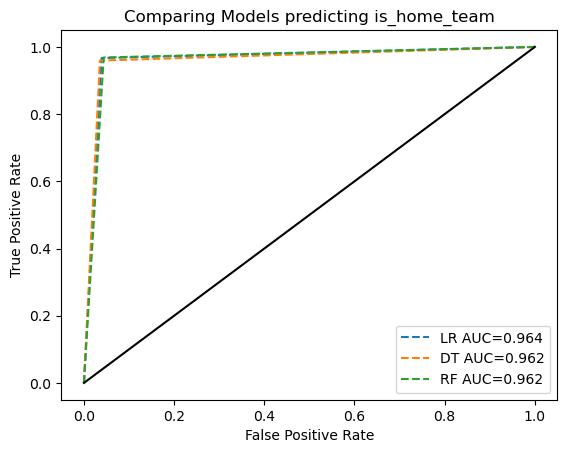

In [67]:
plt.plot(logit_fpr, logit_tpr, linestyle='--', label='{}{:.3f}'.format("LR AUC=", logit_auc))
plt.plot(dt_fpr, dt_tpr, linestyle='--', label='{}{:.3f}'.format("DT AUC=", dt_auc))
plt.plot(rf_fpr, rf_tpr, linestyle='--', label='{}{:.3f}'.format("RF AUC=", rf_auc))
plt.plot([0,1], [0,1], linestyle='solid', c='k')


plt.title('Comparing Models predicting is_home_team')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## additional ideas

*potential future todos*: 
- from sklearn.model_selection, cross_validation_score?
- create confusion matrix for each and use cm to also calc basic metrics like recall, precision, and f1 score
- determine feature importance? (although it would be subject to change based on the random state)
- bigger forest flattened into single tree?